In [17]:
import torch
from torch import nn
import pandas as pd
import numpy as np
from pacmagic_deeplearning.modeling.classifiers.bayesian.train_utils import make_performance_uncertainty_plot, cross_entropy
from torch.optim import SGD
import matplotlib.pyplot as plt
import seaborn as sns
from pacmagic.visualizing.model_plots import plot_calibration_curve

In [2]:
class MCDropout(nn.Module):
    """Simple MLP with dropout option.

    Parameters
    ----------
    in_dim: int
        Number of features in
    n_classes: int
        Number of classes
    p: float
        Dropout probability.
    """

    def __init__(self,
                 in_dim: int,
                 n_classes: int,
                 hidden_dims: tuple = (32, 32),
                 p: float = 0.1,
                 class_weights: list = None):
        super(MCDropout, self).__init__()
        self.dropout_p: float = p

        self.architecture: list = [in_dim] + [dim for dim in hidden_dims] + [n_classes]

        self.layers: list = []

        # Add linear combinations to the forward function. So iterating up to the n-1th layer and
        # adding combinations up to the nth layer.
        for i in range(len(self.architecture) - 1):
            self.layers.append(nn.Linear(self.architecture[i], self.architecture[i + 1]))

            # Don't add these in the final linear combination.
            if i < len(self.architecture) - 2:
                self.layers.append(nn.ReLU())
                self.layers.append(nn.Dropout(p=self.dropout_p))

        self.f: nn.Sequential = nn.Sequential(*self.layers)
        self.n_classes: int = n_classes
        self.in_dim: int = in_dim
        self.n_samples = 512

        weight_tensor = None  # Placeholder
        if self.n_classes == 1:
            if class_weights is not None:
                weight_tensor = torch.Tensor([class_weights[1]])
            self.nll = nn.BCEWithLogitsLoss(pos_weight=weight_tensor, reduction='sum')

        else:
            if class_weights is not None:
                weight_tensor = torch.Tensor(class_weights)
            self.nll = nn.CrossEntropyLoss(weight=weight_tensor, reduction='sum')

    def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
        """Pytorch forward funcion.

        Parameters
        ----------
        input_tensor: torch.Tensor
            input tensor.

        Returns
        -------
        output_tensor: torch.Tensor
            output tensor.
        """
        if len(input_tensor.shape) > 2:
            x: torch.Tensor = input_tensor.view(-1, self.in_dim)
        else:
            x = input_tensor
        output_tensor: torch.Tensor = self.f(x)
        return output_tensor


In [3]:
X_train = pd.read_csv('../../data/MIMIC/X_train_processed.csv')
y_train = pd.read_csv('../../data/MIMIC/y_train.csv')

X_test = pd.read_csv('../../data/MIMIC/X_test_processed.csv')
y_test = pd.read_csv('../../data/MIMIC/y_test.csv')

In [4]:
model = MCDropout(X_train.shape[1], 1, (64,))

In [5]:
data = torch.from_numpy(X_train.values).float()
target = torch.from_numpy(y_train.values).float()

In [6]:
data_val = torch.from_numpy(X_test.values).float()
target_val = torch.from_numpy(y_test.values).float()

In [7]:
# optimizer = SGD(model.parameters(), lr=5e-1, momentum=0.9, nesterov=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [8]:
best_val_loss = np.inf
patience = 0

for epoch_idx in range(10000):
    
    model.train()
    outputs = model(data)
    loss = model.nll(outputs, target)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch_idx % 10 == 0:
        
        model.eval()
        outputs_val = model(data_val)
        loss_val = model.nll(outputs_val, target_val)
            
        print(loss_val.item())
            
        if loss_val.item() < best_val_loss:
            best_val_loss = loss_val.item()
        else:
            patience += 1
            
            if patience == 8:
                break

2651.1435546875
1557.883544921875
1303.6202392578125
1200.337890625
1108.0855712890625
1051.273193359375
1010.7648315429688
966.73193359375
923.9285888671875
890.2086791992188
865.1632690429688
848.0828857421875
837.227294921875
830.0072021484375
824.9496459960938
821.0396118164062
818.1698608398438
815.819580078125
813.7357177734375
811.9603271484375
810.2178344726562
808.5146484375
806.7763061523438
804.9734497070312
803.2106323242188
801.3094482421875
799.4922485351562
797.7481689453125
795.6770629882812
793.8637084960938
791.9667358398438
789.7805786132812
787.4576416015625
785.27978515625
783.2293090820312
780.888916015625
778.5805053710938
776.4281616210938
773.77685546875
771.5921020507812
769.0671997070312
766.6652221679688
764.312744140625
761.9861450195312
759.3390502929688
757.2533569335938
754.3800659179688
752.2095336914062
749.7398681640625
747.5719604492188
745.504638671875
744.3260498046875
741.8882446289062
739.3385620117188
738.347900390625
736.7791748046875
735.31341

In [9]:
with torch.no_grad():
    model.train()
    outputs = torch.sigmoid(torch.stack([model(data_val) for _ in range(512)])).squeeze(-1)

In [10]:
probs = outputs.mean(0).numpy()
stds = outputs.std(0).numpy()

In [11]:
cutoff = np.percentile(probs, 100 * (1-y_train.values.mean()))

preds = probs > cutoff

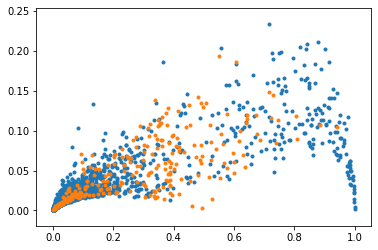

In [12]:
plt.scatter(probs[preds == y_test.squeeze().values], stds[preds == y_test.squeeze().values], marker='.')
plt.scatter(probs[preds != y_test.squeeze().values], stds[preds != y_test.squeeze().values], marker='.')

In [13]:
y_true = y_test.squeeze().values

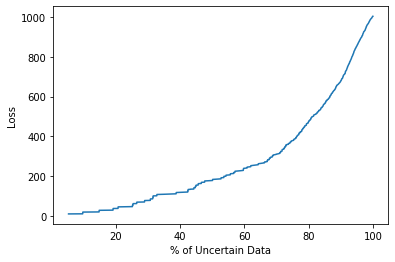

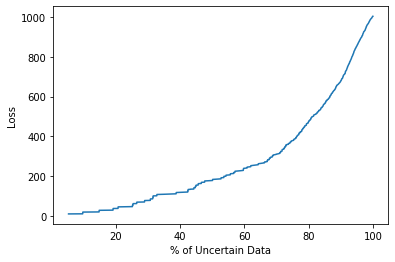

In [14]:
make_performance_uncertainty_plot(y_true, probs, stds, 'Loss', performance_fn_args={'reduction': 'sum'})

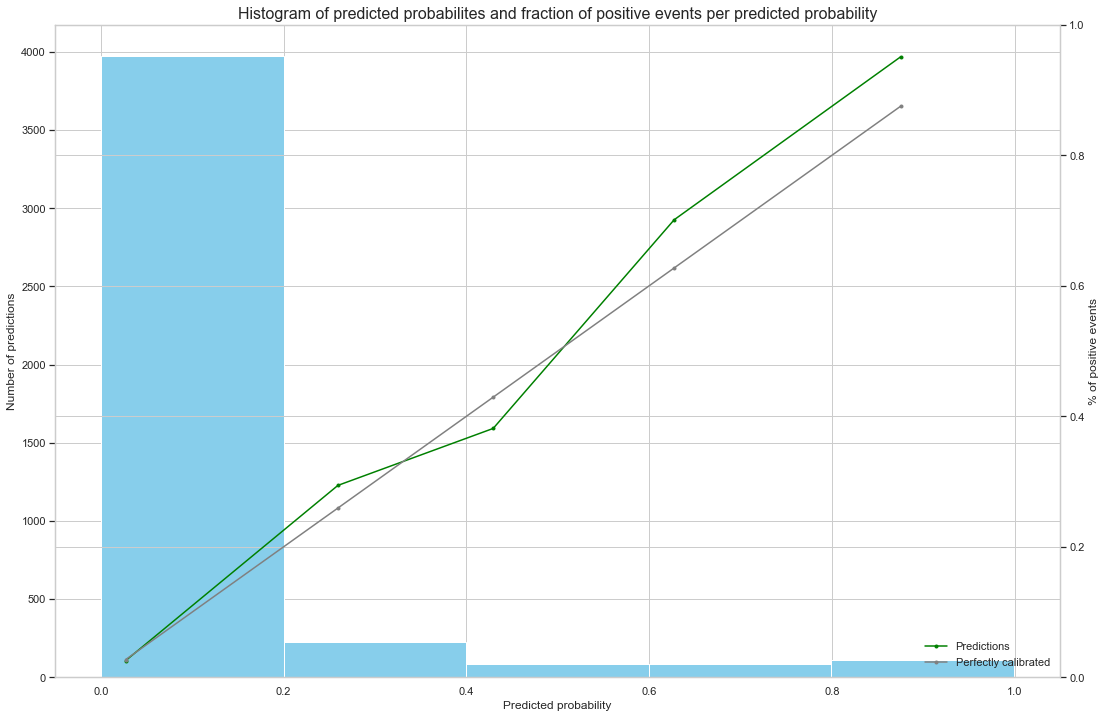

In [16]:
plot_calibration_curve(y_true, probs)

In [19]:
# loss at 100%
cross_entropy(y_true, probs, reduction='sum')

1004.580573302781

In [20]:
# loss at 50%

y_50 = y_true[stds.argsort()[:int(0.5 * len(stds))]]
y_prob_50 = probs[stds.argsort()[:int(0.5 * len(stds))]]

In [21]:
cross_entropy(y_50, y_prob_50, reduction='sum')

178.16665400619968